# IsBit Research and Testing Notebook

## Initial Plan

First plan is to split the data set of 5451 question text data into three data sets. The data sets are described below how they are formatted, the first one containing 80% of the parent data is for local training of different clustering models. The remaining 20% are further devided into two unseen test sets of 10% each where the second one is for local evaluation of models hence containg the coarse-label. and one for remote testing exported to the application.

`ML/data/QAQC_v1/swe_local_train.csv`: 

Is the data source that is preprocessed and splitted into three slices.

`ML/data/QAQC_v1/splits/local_train.csv `:

Is the first mentioned data set where data rows formatted as: `Hur utvecklades träldomen i Ryssland?`. The question to train the clustering models on. 

`ML/data/QAQC_v1/splits/local_test.csv`: 

Is the second data set formatted as `Hur utvecklades träldomen i Ryssland?, DESC`.  The question with coarse lable for local evaluation.

`ML/data/QAQC_v1/splits/remote_test.csv` :

Is the third data set formatted as the second one, ment to be used for user-tests exported to the application.

---

## QAQC Preprocessing

The following section will preprocess and split the source data into the three mentioned data slices, keep in mind that all data file names are in the .gitignore to avoid pushing data files to origin, download the source data set to the following path `ML/data/QAQC_v1` and run the preprocessing section to slice the data for training and testing. Souce data can be found at `https://spraakbanken.gu.se/en/resources/sveat` 

If furhter preproccessing is need I suggest saving it under `ML/data/QAQC_v2/` and inserting created file names into .gitignore.

The cells below will filter the source data and create new formatted csv files with the following changes in format compared to the source data,

- Removing commas inside the text field replacing then with pipe signs | .
- Removing outer quotations marks of the textfield.
- Insert escape chars where needed, mostly text fields containing quotes. 

Exampels of both raw and processed data files with some normal and edge cases in the data rows can be found under `ML/data_exampels`

In [1]:

# run pip install with the requirements.txt

# or run these pip intall 
# > pip install scikit-learn
# > pip install -U sentence-transformers
# > pip install seaborn

# or uncomment lines below and run this cell.
#'%pip install scikit-learn'
#'%pip install sentence-transformers'
#'%pip install seaborn'

'%pip install seaborn'

Removing of commas and quotations marks.

In [4]:
import pandas as pd
import csv
import re
import os

source_path = "data/QAQC_v1/swe_qaqc_train.csv"        # path to the source data, need to be downloaded ignored for git
output_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"   # set the same output path to not push data to git

# helper to remove outer quotation marks
def strip_outer_quotationmarks(q):
    if q.startswith('"') and q.endswith('"'):
        q = q[1:-1]  
    return q.strip()

# helper to remove commas in the question text, causes problems since the cols are set by commas in csv file
def replace_commas(line):
    pattern = r'"([^"]*?)"'
    def replace_commas(match):
        return '"' + match.group(1).replace(',', '|') + '"'
    return re.sub(pattern, replace_commas, line)

def process_csv(source_data_path, output_data_path, temp_file_path="temp_file.csv"):
    with open(source_data_path, 'r', encoding='utf-8') as infile:
        modified_lines = [replace_commas(line.strip()) for line in infile]

    with open(temp_file_path, 'w', encoding='utf-8', newline='') as outfile:
        outfile.write('\n'.join(modified_lines))

    temp_data = pd.read_csv(temp_file_path, quoting=csv.QUOTE_NONE)  
    questions = temp_data["text"].tolist()
    no_comma_questions = [strip_outer_quotationmarks(q) for q in questions]

    coarse_labels = list(map(lambda x: x.split(":")[0], temp_data["verbose label"].tolist())) # only keep the coarse lable 
    zipped = list(zip(no_comma_questions, coarse_labels))

    with open(output_data_path, 'w', encoding='utf-8', newline='') as outfile:
        writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(["text", "coarse label"])
        writer.writerows(zipped)

    if os.path.exists(temp_file_path):
        os.remove(temp_file_path)


    #print(f"Processed data saved to {output_data_path}") # trace print
    return zipped

# data formatted and ready for splitting 
process_csv(source_path, output_path)

[('Hur utvecklades träldomen i Ryssland?', 'DESC'),
 ('Vilka filmer inkluderade karaktären Popeye Doyle?', 'ENTY'),
 ('Hur kan jag hitta en lista över kändisars riktiga namn?', 'DESC'),
 ('Vilken fjäderfä fångar rampljuset efter det kinesiska apans år?', 'ENTY'),
 ('Vad är den fullständiga formen av .com?', 'ABBR'),
 ('Vilken föraktlig skurk stal korken från min lunch?', 'HUM'),
 ('Vilket lag blev basebollens St. Louis Browns?', 'HUM'),
 ('Vad är det äldsta yrket?', 'HUM'),
 ('Vad är leverenzymer?', 'DESC'),
 ('Namnge den ärriga prisjägaren i The Old West.', 'HUM'),
 ('När föddes Ozzy Osbourne?', 'NUM'),
 ('Varför faller tyngre föremål snabbare nedåt?', 'DESC'),
 ('Vem var Yankees stolthet?', 'HUM'),
 ('Vem dödade Gandhi?', 'HUM'),
 ('Vad anses vara den dyraste katastrofen som försäkringsbranschen någonsin har stött på?',
  'ENTY'),
 ('Vilken utbredd amerikansk stat har flest flygplatser?', 'LOC'),
 ('Vad behandlade den enda upphävda ändringen av USA:s konstitution?', 'DESC'),
 ('Hur m

Data-split

Splits the formatted data into 80% local training data, 10% local test data and 10% remote user test data.

In [5]:
from sklearn.model_selection import train_test_split

def data_split(source_data_path, split_path):
    
    data = pd.read_csv(source_data_path)
    os.makedirs(split_path, exist_ok=True)
    
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['coarse label'])
    local_test_data, remote_test_data = train_test_split(test_data, test_size=0.5, random_state=42, shuffle=True, stratify=test_data['coarse label'])
    
    local_train_data = train_data[['text']].copy()  # no need for the lable that wont be used as a lable
    
    local_test_data_for_eval = local_test_data[['text', 'coarse label']].copy()
    remote_test_data_for_eval = remote_test_data[['text', 'coarse label']].copy()
    
    local_train_file = os.path.join(split_path, "local_train.csv")
    local_test_file = os.path.join(split_path, "local_test.csv")
    remote_test_file = os.path.join(split_path, "remote_test.csv")
    
    local_train_data.to_csv(local_train_file, index=False, header=True)
    local_test_data_for_eval.to_csv(local_test_file, index=False, header=True)
    remote_test_data_for_eval.to_csv(remote_test_file, index=False, header=True)
    
    print(f"Data splits saved to: {split_path}")


source_path = "data/QAQC_v1/swe_qaqc_prep_train.csv"
split_path = "data/QAQC_v1/splits/"
data_split(source_path, split_path)


Data splits saved to: data/QAQC_v1/splits/


---
# SentenceTransformers

Testing pre trained model referenced on official page of SentenceTransformer

C:\Users\moell\AppData\Roaming\Python\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
C:\Users\moell\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\moell\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_i

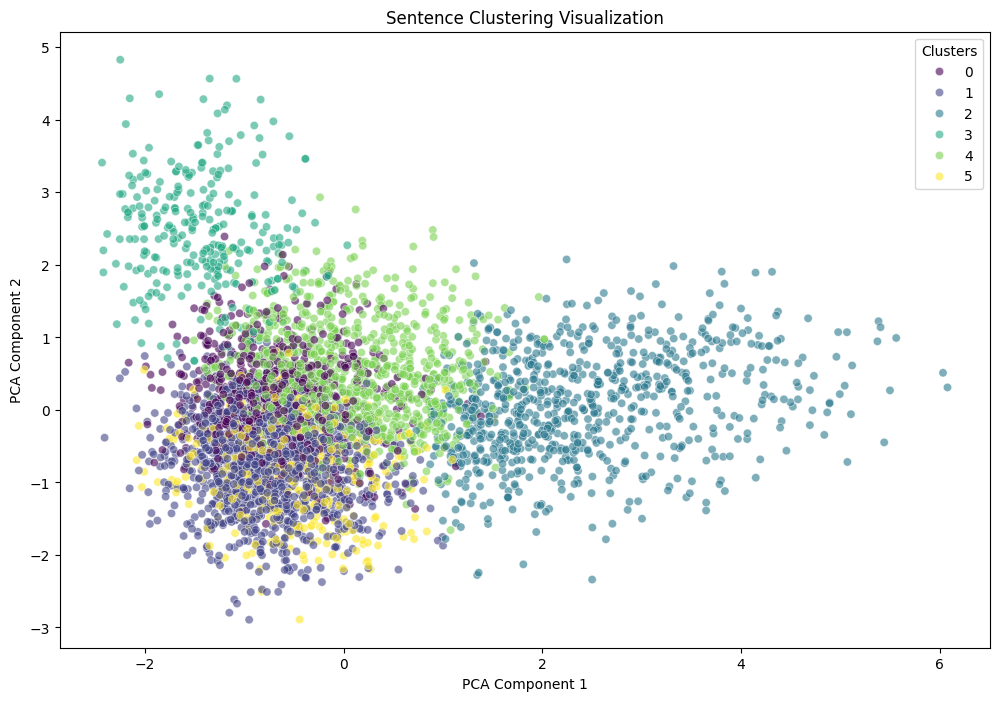

{}

In [1]:


from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


train_data_path = 'data/QAQC_v1/splits/local_train.csv'
data = pd.read_csv(train_data_path)
sentences = data['text'].tolist() 

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences, convert_to_tensor=True)
num_clusters = 6 # coarse lables: [LOC, HUM, DESC, ENTY, ABBR, NUM] 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings.cpu().numpy())
clusters = kmeans.labels_

# reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings.cpu().numpy())

# frame
cluster_df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
cluster_df['cluster'] = clusters

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cluster_df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.6)
plt.title('Sentence Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Clusters')
plt.show()
